# Part II - (Loan Data From Prosper)
### by (Edoka Chisom)

## Investigation Overview

In this data wrangling I was interested in 4 main things:
1. What factors affects the borrower’s APR or interest rate?
2. What factors affect a loan’s outcome status?
3. What factors affect the Prosper rating of a borrower?

## Dataset Overview

This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, borrower's Prosper rating, loan term, borrower's stated monthly income, as well as many other features such as borrower's employment status, debt to income ratio and many others.

This data dictionary explains the variables in the data set. We will not be exploring all of the variables, we will focus on just the very important ones.Focusing our exploration on about 10-15 of them

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load the dataset into pandas
loans = pd.read_csv("prosperLoanData.csv")
loans.sample(3)

# make a copy of the original dataset
loan = loans.copy()
loan.to_csv("loan.csv",index=False)


# remove redundant and uninteresting columns
loan = loan.drop(columns=['ListingKey','ListingNumber','BorrowerRate',"CreditGrade",
'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn',"ClosedDate",
'GroupKey', 'FirstRecordedCreditLine','FirstRecordedCreditLine','Occupation',
'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years',
'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months','AvailableBankcardCredit',
'TotalInquiries','OpenCreditLines','DelinquenciesLast7Years','PublicRecordsLast10Years','LoanCurrentDaysDelinquent',
'PublicRecordsLast12Months','RevolvingCreditBalance','BankcardUtilization','LoanKey','TotalProsperLoans',
'TotalProsperPaymentsBilled','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','PercentFunded',
'ProsperPaymentsOneMonthPlusLate','ProsperPrincipalBorrowed','ProsperPrincipalOutstanding','Investors',
'ScorexChangeAtTimeOfListing','LoanFirstDefaultedCycleNumber','LoanNumber','LoanOriginationDate','AmountDelinquent',
'LoanOriginationQuarter','MemberKey','LP_CustomerPayments','CreditScoreRangeLower', 'CreditScoreRangeUpper','Recommendations',
'LP_CustomerPrincipalPayments','LP_InterestandFees','LP_ServiceFees','DateCreditPulled','TotalTrades','LoanMonthsSinceOrigination',
'LP_CollectionFees','LP_GrossPrincipalLoss','LP_NetPrincipalLoss','BorrowerState','ListingCreationDate',"IncomeRange",
'LP_NonPrincipalRecoverypayments','InvestmentFromFriendsCount','InvestmentFromFriendsAmount','TradesOpenedLast6Months'])

## Visualization 1

About 50% of the loans are currently active and 33% of loans have been completed(that is paid fully). I want to query this data more to know what factors affect a loan status specifically Chargedoff and defaulted loans which both amount to about 16% of loans

In [3]:
loan['LoanStatus'] = loan['LoanStatus'].replace({'Past Due (1-15 days)':'PastDue', 'Past Due (31-60 days)': 'PastDue',
                           'Past Due (61-90 days)': 'PastDue','Past Due (91-120 days)' : 'PastDue', 
                           'Past Due (16-30 days)' : 'PastDue','Past Due (>120 days)' : 'PastDue'})

loanstatus_count = loan['LoanStatus'].value_counts()

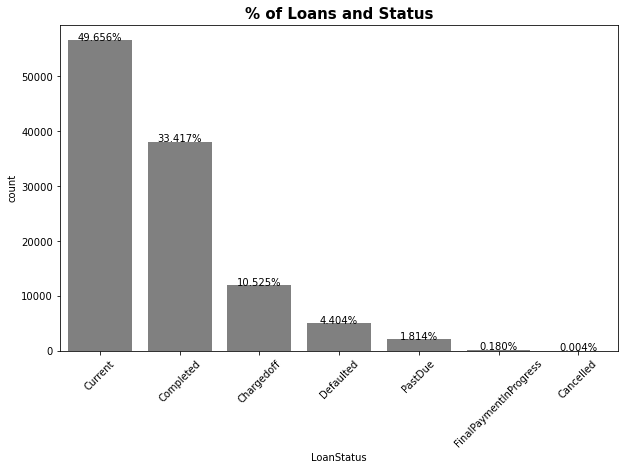

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(data=loan, x ='LoanStatus', color ='grey', order = loanstatus_count.index)
plt.xticks(rotation=45)

#  Logic to print the proportion text on the bars
for i in range(len(loanstatus_count)):
    count = loanstatus_count[i]
    ptr_str = '{:.3f}%'.format(count*100/loan.shape[0])
    plt.text(i,count,ptr_str, ha = 'center')
plt.title('% of Loans and Status',size=15,fontweight="bold");

## Visualization 2

Borrower APR follows same patten as lender yield.  This means that the more a borrowers pays on a loan the more the lender gains

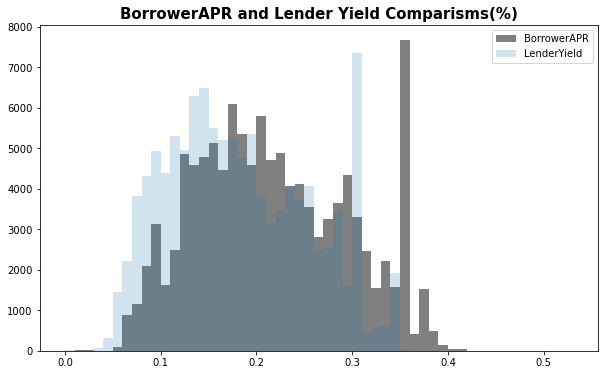

In [5]:
plt.figure(figsize=(10,6))
binapr = np.arange(0,loan['BorrowerAPR'].max()+0.02,0.01)
plt.hist(loan['BorrowerAPR'],bins=binapr, color = 'grey',label= 'BorrowerAPR')

bin = np.arange(0,loan['LenderYield'].max()+0.02,0.01)
plt.hist(loan['LenderYield'],bins=bin,alpha=0.2,label='LenderYield')
plt.title('BorrowerAPR and Lender Yield Comparisms(%)',size=15,fontweight="bold")
plt.legend();

## Visualization 3

In [6]:
# convert ProsperRating(Alpha) to ordered categorical datatype
ordinal_rating = {"ProsperRating (Alpha)": ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']}
ordered_var = pd.api.types.CategoricalDtype(categories = ordinal_rating['ProsperRating (Alpha)'],ordered = True)

In [13]:
loan["ProsperRating (Alpha)"] = loan["ProsperRating (Alpha)"].astype(ordered_var)

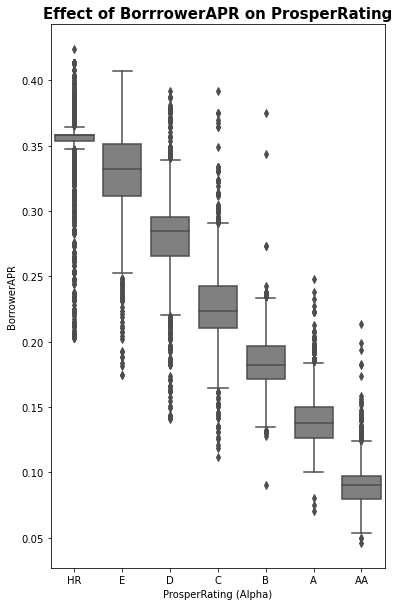

In [14]:
plt.figure(figsize=(6,10))
sns.boxplot(data=loan,x='ProsperRating (Alpha)',y='BorrowerAPR',color='grey');
plt.title('Effect of BorrrowerAPR on ProsperRating',size=15,fontweight="bold");

The borrower APR is negatively correlated with the ProsperRating 

Loans with high original loan amount were positively corrrelated with ProsperRating same goes with StatedMonthlyIncome, this implies that people who earned more could borrow more than others and generally have greater ProsperRating.

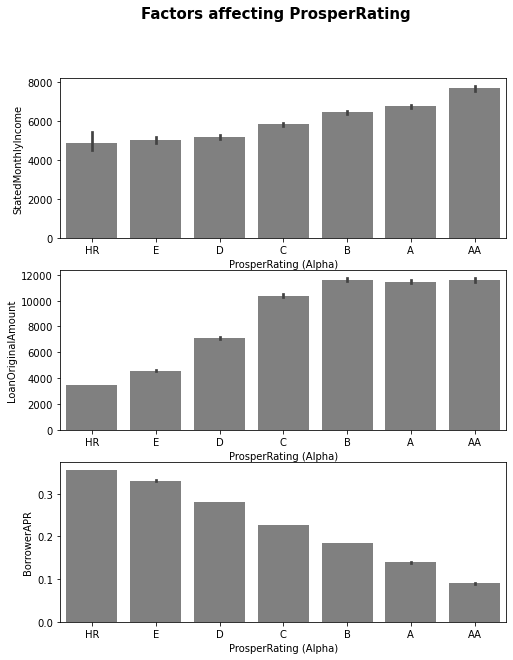

In [9]:
fig,ax = plt.subplots(figsize=(8,10),nrows=3)
sns.barplot(data=loan,x='ProsperRating (Alpha)',y='StatedMonthlyIncome',color ='grey',ax=ax[0])
sns.barplot(data=loan,x='ProsperRating (Alpha)',y='LoanOriginalAmount',color ='grey',ax=ax[1])
sns.barplot(data=loan,x='ProsperRating (Alpha)',y='BorrowerAPR',color ='grey',ax=ax[2])

plt.suptitle('Factors affecting ProsperRating',size=15,fontweight="bold");

## Visualization 4

Loans with smaller StatedMonthly income are most likely to be defaulted and charged off. The same goes for loans with high BorrowerAPR

In [10]:
def impute_outliers_IQR(col):
    
    # function to replace outliers with median value
    q1=col.quantile(0.25)

    q3=col.quantile(0.75)

    IQR=q3-q1

    # max value for loans not in upper outliers
    upper = col[~(col>(q3+1.5*IQR))].max()

    #min values for loans not in lower outliers
    lower = col[~(col<(q1-1.5*IQR))].min()

    col = np.where(col > upper,col.median(),np.where(col < lower,col.median(),col))

    return col
loan.StatedMonthlyIncome = impute_outliers_IQR(loan.StatedMonthlyIncome)

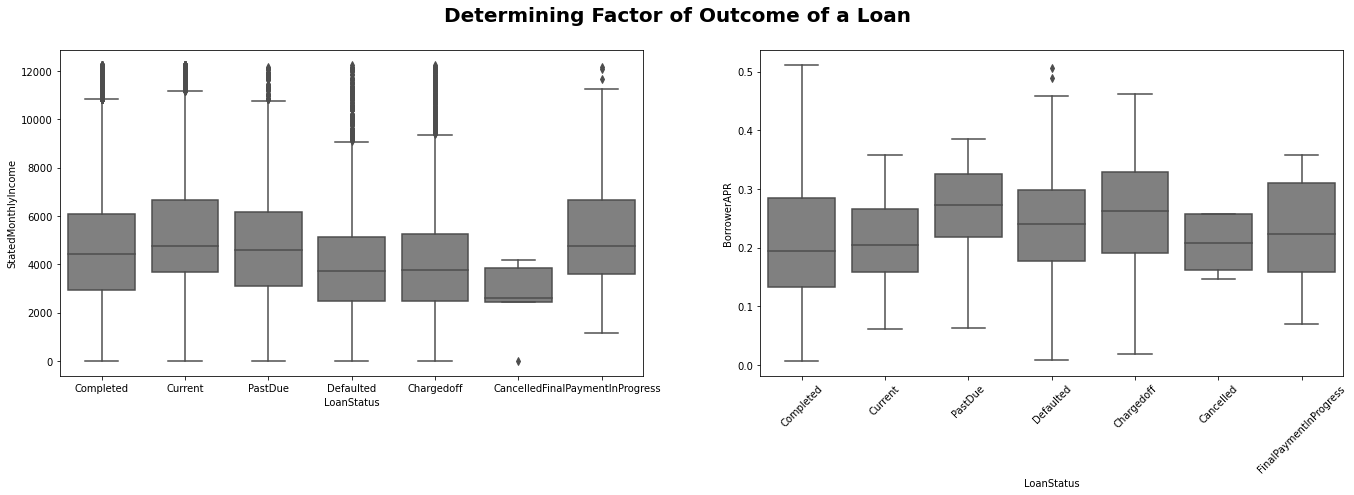

In [11]:
fig,ax = plt.subplots(figsize=(23,6),ncols=2)
sns.boxplot(data=loan,x='LoanStatus',y='StatedMonthlyIncome',color='grey',ax=ax[0])
plt.xticks(rotation=45);

sns.boxplot(data=loan,x='LoanStatus',y='BorrowerAPR',color='grey',ax=ax[1])
plt.xticks(rotation=45)

plt.suptitle('Determining Factor of Outcome of a Loan ',size=20,fontweight="bold");

## Visualization 5

The borrower APR decrease with the increase of borrow term for people with HR-C raings. But for people with B-AA ratings, the APR increase with the increase of borrow term.

## Visualization 6

From the visual below we see that lower ratings like HR,E,D and C are mainly at the bottom left which means low ratings are given to people with low monthly income and lower loans.

Also, higher ratings were given to people with high monthly income and loans as shown by the top right side of the graph

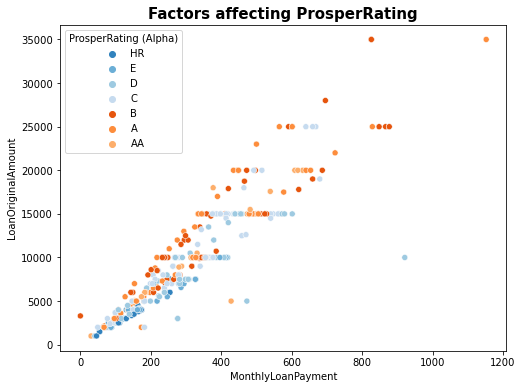

In [12]:
loan_sample = loan.sample(n=500,replace=False)
fig = plt.figure(figsize = [8,6])
sns.scatterplot(data=loan_sample,x='MonthlyLoanPayment',y='LoanOriginalAmount',hue='ProsperRating (Alpha)',
               palette='tab20c')
plt.title('Factors affecting ProsperRating',size=15,fontweight="bold");